In [1]:
import copy
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, "../src/")


In [2]:
# Plot params
mpl.style.use("seaborn-dark")
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['figure.dpi'] = 85
mpl.rcParams['axes.labelsize'] = 'large'

# This is the largest possible value of the logloss
logloss_inf_limit = -np.log(np.finfo('float').eps)


In [102]:
# Fixed var
res_path = osp.join('..', 'output', 'real_data_20200827_140859', 'results.csv')

# Adaptive var
res_path = osp.join('..', 'output', 'real_data_20200827_150854', 'results.csv')
res_path = osp.join('..', 'output', 'real_data_20200827_160804', 'results.csv')

res_path = osp.join('..', 'output', 'real_data_20200831_160811', 'results.csv') # train+test variance
res_path = osp.join('..', 'output', 'real_data_20200904_160955', 'results.csv') 
res_path = osp.join('..', 'output', 'real_data_20200905_150907', 'results.csv') 



res_df = pd.read_csv(res_path)
print(res_df.columns)
print('trainset_size= ',res_df.trainset_size.unique())
res_df.head(5)


Index(['dataset_name', 'trainset_size', 'trail_num', 'valset_size',
       'testset_size', 'num_features', 'mn_test_logloss', 'mn_test_mse',
       'mn_theta_norm', 'mn_variance', 'mn_adaptive_var_test_logloss',
       'mn_adaptive_var_variance', 'genie_valset_mean_var_test_mse',
       'genie_valset_mean_var_test_logloss',
       'genie_valset_mean_var_theta_norm', 'genie_valset_mean_var_variance',
       'genie_adaptive_var_var_test_mse',
       'genie_adaptive_var_var_test_logloss',
       'genie_adaptive_var_var_theta_norm', 'genie_adaptive_var_var_variance',
       'genie_mn_var_var_test_mse', 'genie_mn_var_var_test_logloss',
       'genie_mn_var_var_theta_norm', 'genie_mn_var_var_variance',
       'genie_valset_median_var_test_mse',
       'genie_valset_median_var_test_logloss',
       'genie_valset_median_var_theta_norm',
       'genie_valset_median_var_variance',
       'empirical_pnml_valset_mean_var_regret',
       'empirical_pnml_valset_mean_var_test_logloss',
       'empiri

,dataset_name,trainset_size,trail_num,valset_size,testset_size,num_features,mn_test_logloss,mn_test_mse,mn_theta_norm,mn_variance,...,analytical_pnml_regret,analytical_pnml_test_logloss,mdl_lambda_opt,mdl_test_mse,mdl_theta_norm,mdl_test_logloss,mdl_variance,mdl_adaptive_var_test_logloss,mdl_adaptive_var_variance,test_idx
0,645_fri_c3_500_50,4,0,100,100,51,2.308425,2.659220,0.055377,0.933939,...,1.039060,2.029210,[266.24001472],3.348321,0.001221,2.682530,0.930212,2.559528,1.029624,0
1,645_fri_c3_500_50,4,0,100,100,51,1.282857,0.743585,0.055377,0.933939,...,0.945921,1.835912,[266.24001472],0.806269,0.001221,1.316146,0.930212,1.366594,0.521213,1
2,645_fri_c3_500_50,4,0,100,100,51,1.695556,1.514456,0.055377,0.933939,...,1.045295,1.949975,[266.24001472],1.961652,0.001221,1.937179,0.930212,2.080409,0.752290,2
3,645_fri_c3_500_50,4,0,100,100,51,1.468537,1.090412,0.055377,0.933939,...,0.936601,1.844350,[266.24001472],1.559733,0.001221,1.721142,0.930212,1.880798,0.671906,3
4,645_fri_c3_500_50,4,0,100,100,51,0.886271,0.002811,0.055377,0.933939,...,0.911430,1.796196,[266.24001472],0.080084,0.001221,0.925813,0.930212,0.536325,0.375976,4


In [103]:
# List learners
var_types = []
for col in res_df.columns:
    if col.startswith('empirical_pnml_') and col.endswith('_regret'):
        var_type = col.replace('empirical_pnml_','').replace('_regret','')
        var_types.append(var_type)
print(var_types)

['valset_mean_var', 'adaptive_var_var', 'mn_var_var', 'valset_median_var', 'valset_mean_var', 'valset_median_var', 'best_pnml_var']


In [104]:
# # Filter negative regrets
# len_before = len(res_df)
# res_df = res_df[res_df['empirical_pnml_regret'] > 0]
# len_after = len(res_df)
# if len_after != len_before:
#     print(f'Dropped {len_before-len_after} rows from {len_before}')

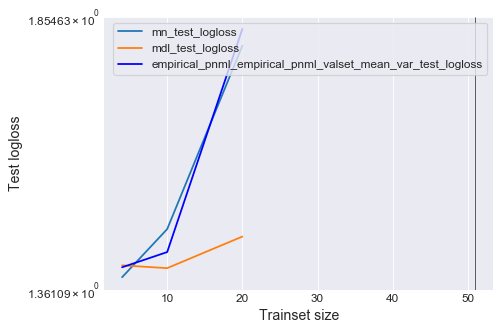

In [113]:
#
var_types = [
#     'valset_mean_var',
#              'adaptive_var_var', 
#              'mn_var_var', 
#              'valset_median_var',  
#              'best_pnml_var',
             'empirical_pnml_valset_mean_var',
#              'empirical_pnml_valset_median_var'
]

# Create mean df
res_mean_df = res_df.groupby('trainset_size').mean().reset_index()
res_std_df = res_df.groupby('trainset_size').std().reset_index()

# Plot learners logloss
keys = ['mn_test_logloss',      'mdl_test_logloss']
genie_keys = [f'genie_{var_type}_test_logloss' for var_type in var_types]
pnml_keys = [f'empirical_pnml_{var_type}_test_logloss' for var_type in var_types]

fig,ax = plt.subplots(1,1)#,figsize=(8,6))
colors = ['b','g','r','c','m','y','k','w']
for i,key in enumerate(keys):
    ax.plot(res_mean_df['trainset_size'],res_mean_df[key], label=key)
for i,var_type in enumerate(var_types):
    genie_key, pnml_key = f'genie_{var_type}_test_logloss', f'empirical_pnml_{var_type}_test_logloss'
    if genie_key in res_mean_df:
        ax.plot(res_mean_df['trainset_size'],res_mean_df[genie_key], '--', label=genie_key, color=colors[i])
    ax.plot(res_mean_df['trainset_size'],res_mean_df[pnml_key] , label=pnml_key,color=colors[i])
ax.axvline(res_mean_df['num_features'].mean(), color='black', linewidth=0.5)
ax.legend(loc=1)
ax.set_yscale('symlog')
ax.set_ylabel('Test logloss')
ax.set_xlabel('Trainset size')

# plt.xscale('log')
# plt.yscale('symlog')
plt.tight_layout()
plt.show()


In [100]:
# Choose specific configurations
dataset_name = '645_fri_c3_500_50'
print('trainset_size: ', res_mean_df.trainset_size.unique())
trainset_size = 4
trail_num = 0
df = res_df[(res_df['dataset_name'] == dataset_name) & \
            (res_df['trainset_size'] == trainset_size) & \
            (res_df['trail_num'] == trail_num)
            ]
df.head(5)

trainset_size:  [ 4 10 20]


,dataset_name,trainset_size,trail_num,valset_size,testset_size,num_features,mn_test_logloss,mn_test_mse,mn_theta_norm,mn_variance,...,analytical_pnml_regret,analytical_pnml_test_logloss,mdl_lambda_opt,mdl_test_mse,mdl_theta_norm,mdl_test_logloss,mdl_variance,mdl_adaptive_var_test_logloss,mdl_adaptive_var_variance,test_idx
0,645_fri_c3_500_50,4,0,100,100,51,0.886438,0.031079,0.104695,0.905449,...,1.152457,2.021733,[101.3712505],0.022205,0.008173,0.860663,0.867494,0.512874,0.421111,0
1,645_fri_c3_500_50,4,0,100,100,51,0.936724,0.122142,0.104695,0.905449,...,1.101865,1.971149,[101.3712505],0.046119,0.008173,0.874446,0.867494,0.546299,0.425894,1
2,645_fri_c3_500_50,4,0,100,100,51,2.020775,2.085246,0.104695,0.905449,...,1.081937,1.974605,[101.3712505],1.571520,0.008173,1.753647,0.867494,1.837199,0.730974,2
3,645_fri_c3_500_50,4,0,100,100,51,1.010464,0.255677,0.104695,0.905449,...,1.175886,2.045191,[101.3712505],0.208840,0.008173,0.968235,0.867494,0.756746,0.458438,3
4,645_fri_c3_500_50,4,0,100,100,51,1.597145,1.318096,0.104695,0.905449,...,1.084135,1.960543,[101.3712505],0.728516,0.008173,1.267762,0.867494,1.278860,0.562373,4


In [87]:
# Plot learners logloss for each sample
df_sorted = df.sort_values(by=['mn_test_logloss'])
df_sorted = df_sorted.reset_index()
keys = ['mn',
        'empirical_pnml',
#         'analytical_pnml',
        'mdl',
        'genie']
for key in keys:
    plt.plot(df_sorted[key + '_test_logloss'], '*', label=key)   
plt.legend()
plt.title('{}: trainset size={}'.format(dataset_name, trainset_size))
plt.xlabel('Test index')
plt.ylabel('Test logloss')
# plt.xscale('log')
plt.tight_layout()
plt.show()

# Worst case:
print('Worst case:')
print(df_sorted[[key + '_test_logloss' for key in keys]].max())

KeyError: 'empirical_pnml_test_logloss'

KeyError: 'genie_theta_norm'

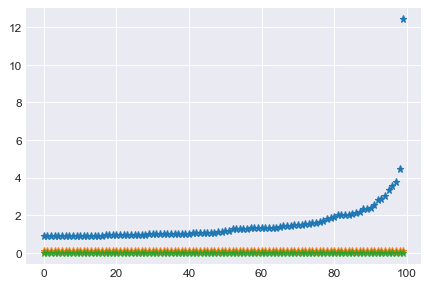

In [88]:
# Plot learners logloss for each sample
df_sorted = df.sort_values(by=['mn_test_logloss'])
df_sorted = df_sorted.reset_index()
keys = ['mn',
        'mdl',
        'genie']

alpha = 1.0
for key in keys:
    plt.plot(df_sorted[key + '_theta_norm'], '*', label=key,alpha=alpha)
    alpha -=0.2
plt.legend()
plt.title('{}: trainset size={}'.format(dataset_name, trainset_size))
plt.xlabel('Test index')
plt.ylabel('Learner Norm')
# plt.xscale('log')
plt.tight_layout()
plt.show()


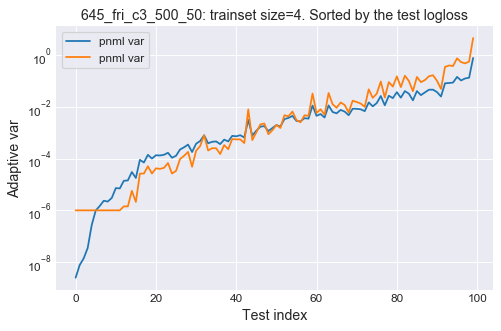

In [101]:
# Variance
# Plot learners logloss for each sample
df_sorted = df.sort_values(by=['mn_test_logloss'])
df_sorted = df_sorted.reset_index()
keys = [
# ['mn',
#         'mn_adaptive_var',
#         'mdl',
#         'mdl_adaptive_var',
#         'genie',
#         'genie_valset_var',
        'genie_adaptive_var',
    'best_pnml_var']
# for key in keys:
#     plt.plot(df_sorted[key + '_variance'], '*', label=key)
# plt.plot(df_sorted['empirical_pnml_regret'], label='regret')
plt.plot(df_sorted['genie_adaptive_var_var_variance'] , label='pnml var')
plt.plot(df_sorted['empirical_pnml_best_pnml_var_variance'] , label='pnml var')
plt.legend()
plt.title('{}: trainset size={}. Sorted by the test logloss'.format(dataset_name, trainset_size))
plt.xlabel('Test index')
plt.ylabel('Adaptive var')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [91]:
# Variance
# Plot learners logloss for each sample
df_sorted = df.sort_values(by=['mn_test_logloss'])
df_sorted = df_sorted.reset_index()
keys = [f'genie_{var_type}_variance' for var_type in var_types]
for key in keys:
    plt.plot(df_sorted[key] , label=key)
plt.legend()
plt.title('{}: trainset size={}. Sorted by the test logloss'.format(dataset_name, trainset_size))
plt.xlabel('Test index')
plt.ylabel('Adaptive var')
plt.yscale('log')
plt.tight_layout()
plt.show()

KeyError: 'genie_best_pnml_var_variance'

In [50]:
df_sorted[[key for key in df_sorted.columns if 'variance' in key]].mean()

mn_variance                                    8.992501e-01
mn_adaptive_var_variance                       2.044996e-01
genie_valset_mean_var_variance                 2.278720e-02
genie_valset_mean_with_train_var_variance      1.369823e-02
genie_adaptive_var_var_variance                1.612714e-02
genie_mn_var_var_variance                      1.131329e+00
genie_valset_median_var_variance               5.029288e-04
genie_valset_median_with_train_var_variance    5.029288e-04
genie_1e-9_variance                            1.000000e-09
genie_1e-6_variance                            1.000000e-06
genie_1e-3_variance                            1.000000e-03
genie_1e-1_variance                            1.000000e-01
mdl_variance                                   9.320821e-01
mdl_adaptive_var_variance                      6.008265e-01
dtype: float64

In [51]:
df_sorted['genie_valset_var_variance']

KeyError: 'genie_valset_var_variance'